# Scenarios

The scenarios are taken from https://twiki.cern.ch/twiki/bin/view/LHCPhysics/SUSYCrossSections.

Modifications:
-   we set the STAUMIX values to maximally mixed for sleptons
-   we manually set the massses of all particles tagged with an @a or {M...} 

In [1]:
#%load_ext nb_black
import hepi


print(hepi.__version__)
import smpl
from smpl import data
import numpy as np
import hepi.resummino as rs
import hepi.util as util
import matplotlib.pyplot as plt

rs.set_path("~/git/resummino/build")
print(rs.get_path())

test_lo = True
analyse  = False # else generation

0.1.12.1
~/git/resummino/build


# aNNLO+NNLL wino


|||||= 5 jobs


/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",
100%|██████████████████████████████| 5/5 [00:00<00:00, 499.51it/s]


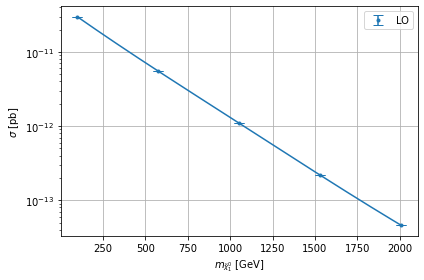

/home/apn/.local/lib/python3.9/site-packages/hepi/input.py:283: RuntimeWarning: Could not set new central scale to average of masses.
  warnings.warn("Could not set new central scale to average of masses.",


|||||= 5 jobs


100%|██████████████████████████████| 5/5 [00:00<00:00, 428.16it/s]


KeyboardInterrupt: 

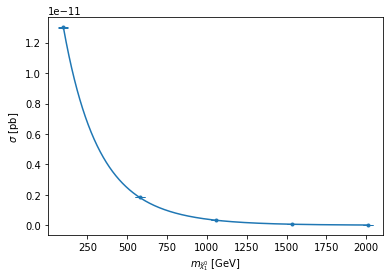

In [2]:
params = [
    "wino.slha",
]
pss = [
    ( 1000023, +1000024),  # N1C1p
    ( 1000023, -1000024),  # N1C1m
    (+1000024, -1000024),  # C1pC1m
]
pdfs = ["PDF4LHC21_40","PDF4LHC15_nlo_30","PDF4LHC21_mc","CT18NNLO"]
for energy in [13000, 13600]:
    for pa, pb in pss:
        for pdf in pdfs:
            hepi.set_output_dir(
                "output_" + str(energy) + "_wino_" + str(pa) + "_" + str(pb) + "/"
            )
            rs.default_resummino_runner.set_output_dir(hepi.get_output_dir())
            for param in params:
                i = hepi.Input(
                    hepi.Order.LO if test_lo else hepi.Order.aNNLO_PLUS_NNLL,
                    energy,
                    pa,
                    pb,
                    param,
                    "PDF4LHC21_40",
                    "PDF4LHC21_40",
                    1.0,
                    1.0,
                    id="0.0.0",
                    precision=0.001,
                    max_iters=50,
                )
                li = [i]
                li = hepi.masses_scan(
                    li,
                    [
                        1000022,
                        1000023,
                        1000024,
                    ],
                    np.linspace(100,2010,3),
                )
                if not test_lo:

                    li = hepi.seven_point_scan(li)
                    li = hepi.pdf_scan(li)
                    # li = hepi.change_where(li, {"precision": 0.0001, "max_iters": 200}, pdfset_nlo=0)
                    if not analyse:
                        rs_dl = rs.run(li, skip=False, run=False, parse=False)
                    else:
                        rs_dl = rs.run(li, skip=True, run=True, parse=True,ignore_error=True)
                        rs_dl = hepi.pdf_errors(li,rs_dl)
                        rs_dl = hepi.scale_errors(li,rs_dl)
                        rs_dl = hepi.combine_errors(rs_dl)
                        hepi.title(li[0])
                        #hepi.mass_plot(rs_dl,"LO_COMBINED",1000022,mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull(),show=True,logy=True,interpolate=True,fill=True,interpolator='cubic',pre=np.log,post=np.exp)
                        #hepi.mass_plot(rs_dl,"NLO_COMBINED",1000022,mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull(),show=True,logy=True,interpolate=True,fill=True,interpolator='cubic',pre=np.log,post=np.exp,init=False)
                        hepi.mass_plot(rs_dl,"aNNLO_PLUS_NNLL_COMBINED",1000022,mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull(),show=True,logy=True,interpolate=True,fill=True,interpolator='cubic',pre=np.log,post=np.exp,init=False)
                        hepi.mass_plot(rs_dl,"aNNLO_PLUS_NNLL_SCALE",1000022,mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull(),show=True,logy=True,interpolate=True,fill=True,interpolator='cubic',pre=np.log,post=np.exp,init=False)
                        hepi.mass_plot(rs_dl,"aNNLO_PLUS_NNLL_PDF",1000022,mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull(),ratio=True,show=True,logy=False,interpolate=True,fill=True,interpolator='cubic',pre=np.log,post=np.exp,init=False)

                else:
                    rs_dl = rs.run(li, skip=True, run=True, parse=True)
                    hepi.mass_plot(rs_dl,"LO",1000022,show=True,interpolator='cubic',pre=np.log,post=np.exp)

# aNNLO+NNLL hino degenerate


In [ ]:
params = [
    "hino.slha",
]
pss = [
    (1000022, +1000024),  # N2C1p
    (1000022, -1000024),  # N2C1m
    (+1000024, -1000024),  # C1pC2m
    (1000022, 1000023),  # N2N1
]
for energy in [13000, 13600]:
    for pa, pb in pss:
        # save to different folders to have some substructure
        hepi.set_output_dir(
            "output_" + str(energy) + "_hino_deg_" + str(pa) + "_" + str(pb) + "/"
        )
        rs.default_resummino_runner.set_output_dir(hepi.get_output_dir())
        for param in params:
            i = hepi.Input(
                hepi.Order.LO if test_lo else hepi.Order.aNNLO_PLUS_NNLL,
                energy,
                pa,
                pb,
                param,
                "PDF4LHC21_40",
                "PDF4LHC21_40",
                1.0,
                1.0,
                id="0.0.0",
                precision=0.001,
                max_iters=50,
            )
            li = [i]
            li = hepi.masses_scan(
                li,
                [
                    1000022,
                    1000023,
                    1000024,
                ],
                range(100, 1510, 100),
                negate=[1000022],
            )
            if not test_lo:
                li = hepi.seven_point_scan(li)
                li = hepi.pdf_scan(li)
                # li = hepi.change_where(li, {"precision": 0.0001, "max_iters": 200}, pdfset_nlo=0)
                if not analyse:
                    rs_dl = rs.run(li, skip=False, run=False, parse=False)
                else:
                    rs_dl = rs.run(li, skip=True, run=True, parse=True,ignore_error=True)
                    rs_dl = hepi.pdf_errors(li,rs_dl)
                    rs_dl = hepi.scale_errors(li,rs_dl)
                    rs_dl = hepi.combine_errors(rs_dl)
                    hepi.title(li[0])
                    #hepi.mass_plot(rs_dl,"LO_COMBINED",1000022,mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull(),show=True,logy=True,interpolate=True,fill=True,interpolator='cubic',pre=np.log,post=np.exp)
                    #hepi.mass_plot(rs_dl,"NLO_COMBINED",1000022,mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull(),show=True,logy=True,interpolate=True,fill=True,interpolator='cubic',pre=np.log,post=np.exp,init=False)
                    hepi.mass_plot(rs_dl,"aNNLO_PLUS_NNLL_COMBINED",1000023,mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull(),show=True,logy=True,interpolate=True,fill=True,interpolator='cubic',pre=np.log,post=np.exp,init=False)
                    hepi.mass_plot(rs_dl,"aNNLO_PLUS_NNLL_SCALE",1000023,mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull(),show=True,logy=True,interpolate=True,fill=True,interpolator='cubic',pre=np.log,post=np.exp,init=False)
                    hepi.mass_plot(rs_dl,"aNNLO_PLUS_NNLL_PDF",1000023,mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull(),ratio=True,show=True,logy=False,interpolate=True,fill=True,interpolator='cubic',pre=np.log,post=np.exp,init=False)
            else:
                rs_dl = rs.run(li, skip=False, run=True, parse=True)
                hepi.mass_plot(rs_dl,"LO",1000023,show=True,interpolator='exp')

# aNNLO+NNLL sleptons

In [ ]:
params = [
    "sleptons.slha",
]
pss = [
    (+1000011, -1000011),  # l_L^+ l_L^-
    (+2000011, -2000011),  # l_R^+ l_R^-
    (+1000015, -1000015),  # l_1^+ l_1^-
]
for energy in [13000, 13600]:
    for pa, pb in pss:
        hepi.set_output_dir("output_" + str(energy) + "_sleptons_" + str(pa) + "_" + str(pb) +"/")
        rs.default_resummino_runner.set_output_dir(hepi.get_output_dir())
        for param in params:
            i = hepi.Input(
                hepi.Order.LO if test_lo else hepi.Order.aNNLO_PLUS_NNLL,
                energy,
                pa,
                pb,
                param,
                "PDF4LHC21_40",
                "PDF4LHC21_40",
                1.0,
                1.0,
                id="0.0.0",
                precision=0.001,
                max_iters=50,
            )
            li = [i]
            li = hepi.masses_scan(
                li,
                [
                    1000011,
                    2000011,
                    1000012,
                    1000013,
                    2000013,
                    1000014,
                    1000015,
                    2000015,
                    1000016,
                ],
                range(100, 1010, 100),
            )
            if not test_lo:
                li = hepi.seven_point_scan(li)
                li = hepi.pdf_scan(li)
                # li = hepi.change_where(li, {"precision": 0.0001, "max_iters": 200}, pdfset_nlo=0)
                if not analyse:
                    rs_dl = rs.run(li, skip=False, run=False, parse=False)
                else:
                    rs_dl = rs.run(li, skip=True, run=True, parse=True,ignore_error=True)
                    rs_dl = hepi.pdf_errors(li,rs_dl)
                    rs_dl = hepi.scale_errors(li,rs_dl)
                    rs_dl = hepi.combine_errors(rs_dl)
                    hepi.title(li[0])
                    #hepi.mass_plot(rs_dl,"LO_COMBINED",1000022,mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull(),show=True,logy=True,interpolate=True,fill=True,interpolator='cubic',pre=np.log,post=np.exp)
                    #hepi.mass_plot(rs_dl,"NLO_COMBINED",1000022,mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull(),show=True,logy=True,interpolate=True,fill=True,interpolator='cubic',pre=np.log,post=np.exp,init=False)
                    hepi.mass_plot(rs_dl,"aNNLO_PLUS_NNLL_COMBINED",1000011,mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull(),show=True,logy=True,interpolate=True,fill=True,interpolator='cubic',pre=np.log,post=np.exp,init=False)
                    hepi.mass_plot(rs_dl,"aNNLO_PLUS_NNLL_SCALE",1000011,mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull(),show=True,logy=True,interpolate=True,fill=True,interpolator='cubic',pre=np.log,post=np.exp,init=False)
                    hepi.mass_plot(rs_dl,"aNNLO_PLUS_NNLL_PDF",1000011,mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull(),ratio=True,show=True,logy=False,interpolate=True,fill=True,interpolator='cubic',pre=np.log,post=np.exp,init=False)
            else:
                rs_dl = rs.run(li, skip=False, run=True, parse=True)
                hepi.mass_plot(rs_dl,"LO",1000011,show=True,interpolator='exp')

# aNNLO+NNLL hino non-degenerate

In [ ]:
params = [
    "higgsino_slha_C1C1.slha",
]
pss = [
    ( 1000022, +1000024),  # N2C1p
    ( 1000022, -1000024),  # N2C1m
    (+1000024, -1000024),  # C1pC1m
    ( 1000022,  1000023),  # N2N1
]
import urllib

dl = hepi.load(
    urllib.request.urlopen(
        "https://raw.githubusercontent.com/APN-Pucky/xsec/master/json/pp13_hinosplit_N2N1_NLO%2BNLL.json"
    ),
    dimensions=2,
)
N1 = dl["N1"]
N2 = dl["N2"]
NX = dl["N1"] / 2 + dl["N2"] / 2
for energy in [13000, 13600]:
    for pa, pb in pss:
        # save to different folders to have some substructure
        hepi.set_output_dir(
            "output_" + str(energy) + "_hino_nondeg_" + str(pa) + "_" + str(pb) + "/"
        )
        rs.default_resummino_runner.set_output_dir(hepi.get_output_dir())
        for param in params:
            i = hepi.Input(
                hepi.Order.LO if test_lo else hepi.Order.aNNLO_PLUS_NNLL,
                energy,
                pa,
                pb,
                param,
                "PDF4LHC21_40",
                "PDF4LHC21_40",
                1.0,
                1.0,
                id="0.0.0",
                precision=0.001,
                max_iters=50,
            )
            li = [i]
            li = hepi.slha_scan_rel(
                li,
                lambda r: [
                    ["MASS", 1000022, N1[r]],
                    ["MASS", 1000023, -N2[r]],
                    ["MASS", 1000024, NX[r]],
                ],
                range(len(N1)),
            )
            if not test_lo:
                li = hepi.seven_point_scan(li)
                li = hepi.pdf_scan(li)
                # li = hepi.change_where(li, {"precision": 0.0001, "max_iters": 200}, pdfset_nlo=0)
                if not analyse:
                    rs_dl = rs.run(li, skip=True, run=False, parse=False)
                else:
                    rs_dl = rs.run(li, skip=True, run=True, parse=True)
                    
                    
                    rs_dl = hepi.pdf_errors(li,rs_dl)
                    rs_dl = hepi.scale_errors(li,rs_dl)
                    rs_dl = hepi.combine_errors(rs_dl)
                    mask = rs_dl["aNNLO_PLUS_NNLL_COMBINED"].notnull()
                    
                    hepi.mapplot(rs_dl[mask],"MASS_1000022","MASS_1000024","aNNLO_PLUS_NNLL_COMBINED",xaxis="$m_{\\tilde{\\chi}_1^0}$ [GeV]",yaxis="$m_{\\tilde{\\chi}_1^-}$ [GeV]" , zaxis="$\\sigma_{\\mathrm{aNNLO+NNLL}}$ [pb]")

                    hepi.title(li[0])

                    xx,yy = data.flatmesh(np.linspace(50,320,100),np.linspace(80,320,100))
                    dll = hepi.interpolate_2d(rs_dl[mask],"MASS_1000022","MASS_1000024","aNNLO_PLUS_NNLL_COMBINED",xx,yy,interpolator="linearnd",pre=np.log,post=np.exp)             
                    hepi.mapplot(dll,"MASS_1000022","MASS_1000024","aNNLO_PLUS_NNLL_COMBINED",xaxis="$m_{\\tilde{\\chi}_1^0}$ [GeV]",yaxis="$m_{\\tilde{\\chi}_1^-}$ [GeV]" , zaxis="$\\sigma_{\\mathrm{aNNLO+NNLL}}$ [pb]",fill_missing=False)
                    hepi.title(li[0])
                
            else:
                rs_dl = rs.run(li, skip=True, run=True, parse=True)
                hepi.mapplot(rs_dl,"MASS_1000022","MASS_1000024","LO",xaxis="$m_{\\tilde{\\chi}_1^0}$ [GeV]",yaxis="$m_{\\tilde{\\chi}_1^-}$ [GeV]" , zaxis="$\\sigma_{\\mathrm{NLO+NLL}}$ [pb]")